In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(14,12)})

# Para suprimir los warnings de scikitlearn por convergencia prematura
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
dec_fraude = pd.read_csv('C:/Users/maria/OneDrive/Escritorio/pontia/Proyecto/Definitivo/dec_fraude.csv')

In [3]:
dec_fraude.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
dec_fraude.head(5)

,t_id,tipo,tiempo,monto,cl_origen,cl_destino,es_fraude,mensaje_alarma,balance_prev_or,balance_post_or,balance_prev_des,balance_post_des
0,0,PAYMENT,2022-09-01 07:00:00,9839.64,C1231006815,M1979787155,0.0,No,170136.0,160296.36,0.0,0.0
1,1,PAYMENT,2022-09-01 07:00:00,1864.28,C1666544295,M2044282225,0.0,No,21249.0,19384.72,0.0,0.0
2,2,TRANSFER,2022-09-01 07:00:00,181.00,C1305486145,C553264065,1.0,No,181.0,0.00,0.0,0.0
3,3,CASH_OUT,2022-09-01 07:00:00,181.00,C840083671,C38997010,1.0,No,181.0,0.00,21182.0,0.0
4,4,PAYMENT,2022-09-01 07:00:00,11668.14,C2048537720,M1230701703,0.0,No,41554.0,29885.86,0.0,0.0


In [5]:
dec_fraude['tipo'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [5]:
# Categorizamos la columna tipo
mapeo = {'PAYMENT': 0, 'TRANSFER': 1, 'CASH_OUT': 2, 'DEBIT': 3, 'CASH_IN': 4}
dec_fraude['tipo_cod'] = dec_fraude['tipo'].map(mapeo)

In [7]:
# Hacemos un estudio de correlacion
corr_matrix = dec_fraude.corr()

C:\Users\maria\AppData\Local\Temp\ipykernel_11580\2039478174.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dec_fraude.corr()


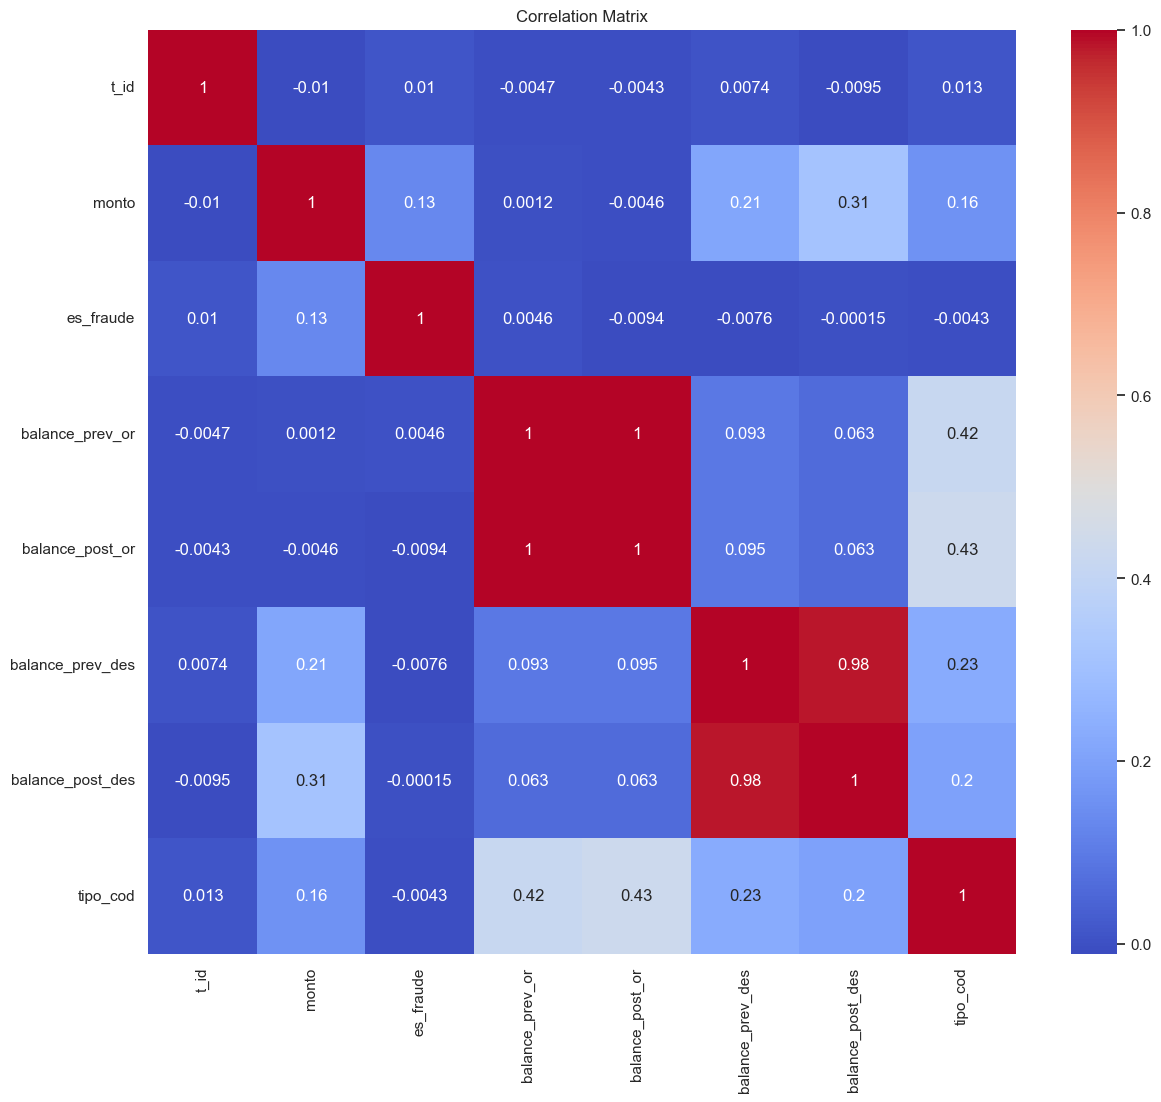

In [8]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [9]:
# Seleccionamos las columnas que vamos a introducir al dataset y el ground truth
X = dec_fraude[['monto','balance_prev_or','balance_post_or','balance_prev_des','balance_post_des', 'tipo_cod']]
Y = dec_fraude[['es_fraude']]

Regresion logistica

In [12]:
print(dec_fraude.shape)

(1450415, 13)


In [13]:
#sns.pairplot(dec_fraude, diag_kind="kde")

In [10]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1015290, 6)
(1015290, 1)
(435125, 6)
(435125, 1)


In [11]:
nulos = dec_fraude.isnull().sum()

In [12]:
nulos

t_id                0
tipo                0
tiempo              0
monto               0
cl_origen           0
cl_destino          0
es_fraude           1
mensaje_alarma      1
balance_prev_or     1
balance_post_or     1
balance_prev_des    1
balance_post_des    1
tipo_cod            0
dtype: int64

In [13]:
mean = X_train.mean(axis=0)

In [14]:
median = X_train.median(axis=0)

In [15]:
pd.concat([mean, median, mean-median], axis=1, keys=["Media", "Mediana", "Diferencia"])

,Media,Mediana,Diferencia
monto,1.618219e+05,79041.22,82780.704461
balance_prev_or,8.694249e+05,15330.00,854094.860857
balance_post_or,8.903263e+05,0.00,890326.299770
balance_prev_des,9.923286e+05,134618.96,857709.688164
balance_post_des,1.119483e+06,227407.94,892075.270554
tipo_cod,1.696498e+00,2.00,-0.303502


In [16]:
#TODO
#Obtener 1.5 el rango intercuartilico
iqrx15 = (X_train.quantile(.75) - X_train.quantile(.25))*1.5
#Obtener los valores maximos
maxs = X_train.max()
#Obtener los valores minimos
mins = X_train.min()
#Definir un limite superior igual a la mediana mas 1.5 veces el rango intercuartilico
sup = median + iqrx15
#Definir un limite inferior igual a la mediana menos 1.5 veces el rango intercuartilico
inf = median - iqrx15
#Comprobar si los valores maximos estan mas alla del limite superior
out_sup = maxs > inf
#Comprobar si los valores minimos estan mas alla del limite inferior
out_inf = maxs < inf
#Mostramos para que variables existen valores atipicos
pd.concat([out_sup, out_inf], axis=1, keys=["Outlier Sup", "Outlier Inf"])

,Outlier Sup,Outlier Inf
monto,True,False
balance_prev_or,True,False
balance_post_or,True,False
balance_prev_des,True,False
balance_post_des,True,False
tipo_cod,True,False


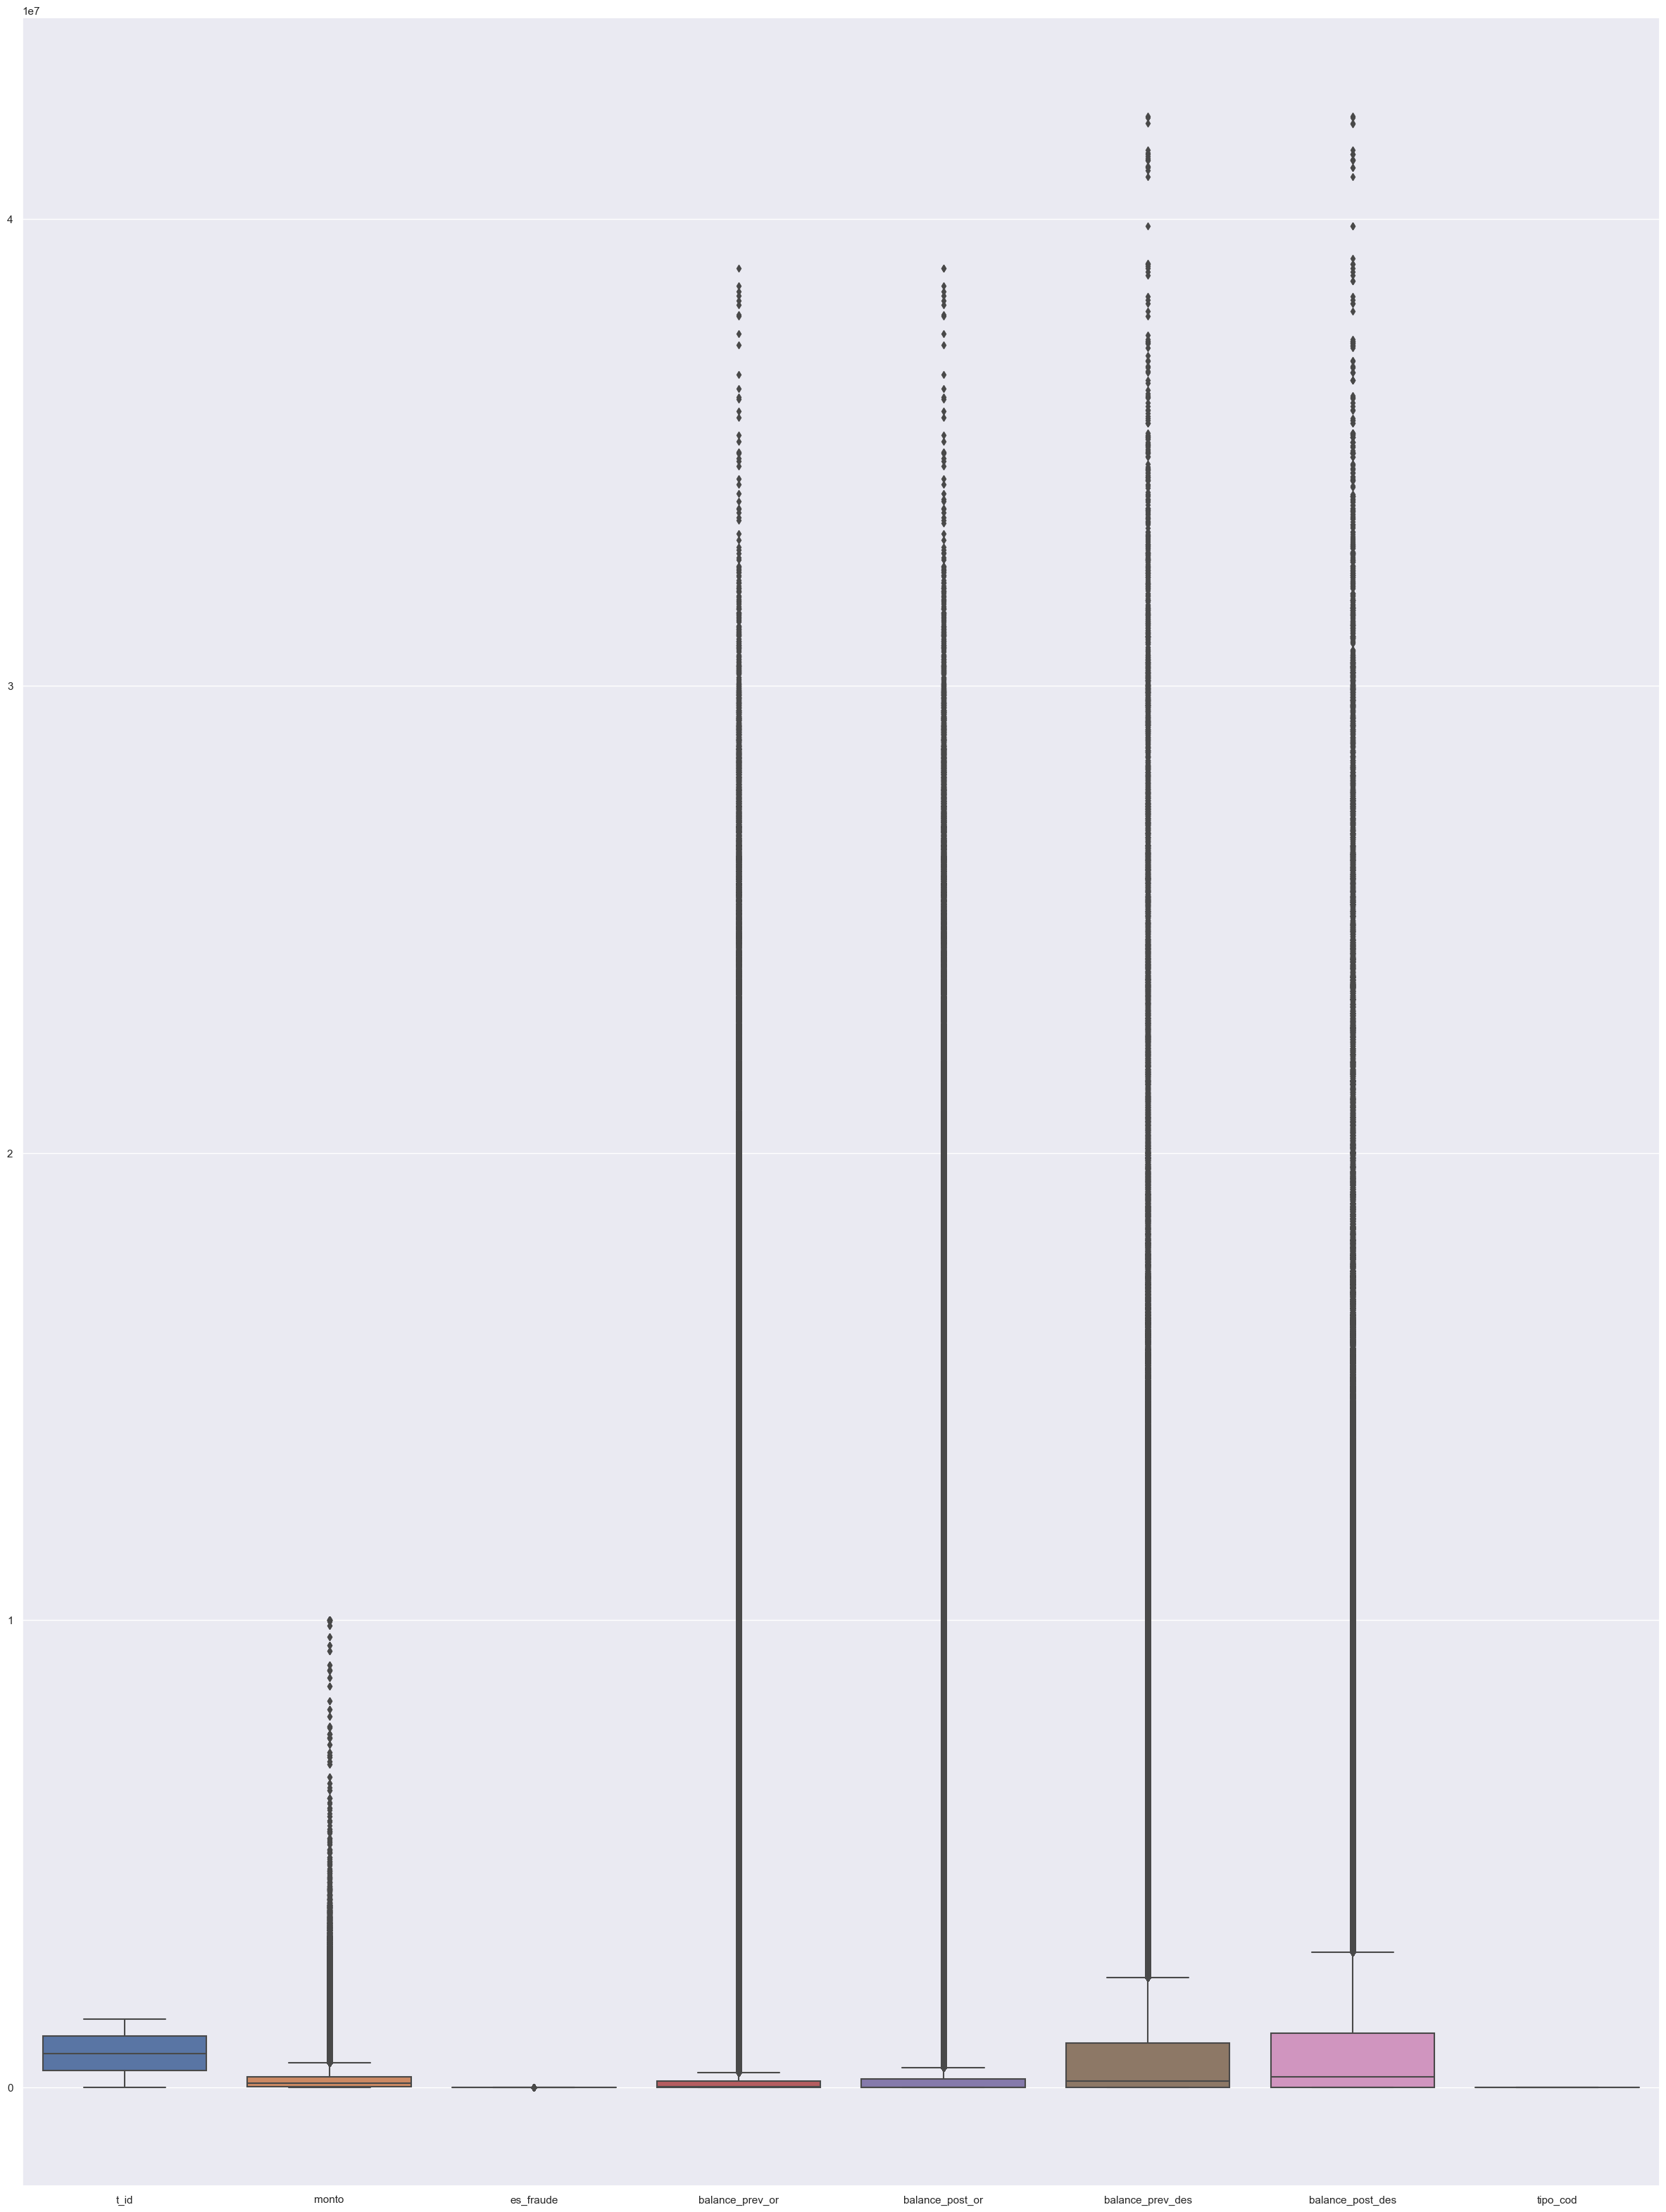

In [17]:
plt.figure(figsize = (30,40))
sns.boxplot(data = dec_fraude)
plt.show()

In [18]:
import pandas as pd
from sklearn.preprocessing import RobustScaler

# Normalizar los datos
scaler = RobustScaler()  # Definir el modelo de normalización
X_train = pd.DataFrame(scaler.fit_transform(X_train))  # Entrenar y normalizar los datos de entrenamiento, ajustamos parametros
X_test = pd.DataFrame(scaler.transform(X_test))  # Normalizar los datos de prueba

# Comprobar el resultado de la normalización
result = pd.concat([X_train.median(), X_test.median(),
                    (X_train.quantile(0.75) - X_train.quantile(0.25)),
                    (X_test.quantile(0.75) - X_test.quantile(0.25))],
                   axis=1,
                   keys=["Train median", "Test median", "Train iqr", "Test iqr"])
print(result)


   Train median  Test median  Train iqr  Test iqr
0           0.0     0.002419        1.0  0.998374
1           0.0    -0.000652        1.0  1.003404
2           0.0     0.000000        1.0  0.996269
3           0.0     0.003039        1.0  0.998610
4           0.0     0.001489        1.0  1.001298
5           0.0     0.000000        1.0  1.000000


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [22]:
#definir y entrenar el modelo de regresion logistica
l_reg = LogisticRegression().fit(X_train, y_train)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [28]:
# obtener las predicciones para el conjunto de datos de testeo
y_est = l_reg.predict(X_test)

NameError: name 'l_reg' is not defined

In [21]:
MSE_tst = mean_squared_error(y_test,y_est)
accuracy = l_reg.score(X_test, y_test)
precision = precision_score(y_test, y_est)
recall = recall_score(y_test, y_est)
#f1_score = f1_score(y_test, y_est)
# Imprimimos el error y precision del modelo
print('MSE : ' + str(MSE_tst))
print('Accuracy: ' + str(accuracy)) #predice,evalua
print('precision: ' + str(precision))
print('recall: ' + str(recall))
#print('f1_score: ' + str(f1_score))

# Finalmente mostramos los datos para acernos una idea de como de cercana
# es la predicción. Se muestra para el atributo mean radius y texture. Cambiar de atributos
# para comprobar otras dimensiones


MSE : 0.000814666725343627
Accuracy: 0.9991853332746564
precision: 0.8942807625649913
recall: 0.41866125760649087


Confusion matrix
[[1906169     122]
 [   1433    1032]]
Normalized confusion matrix
[[9.99936001e-01 6.39986235e-05]
 [5.81338742e-01 4.18661258e-01]]


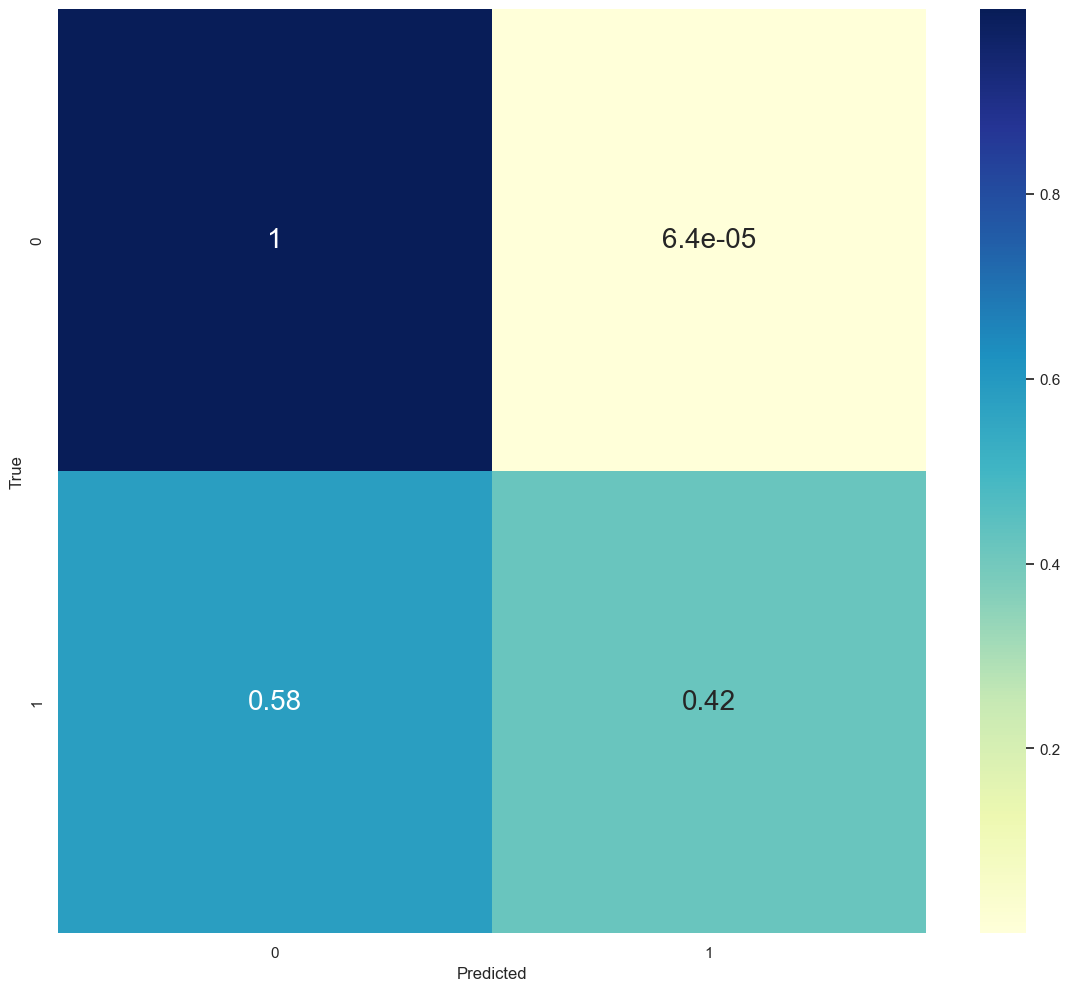

In [22]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

AUC:  0.709298629491493


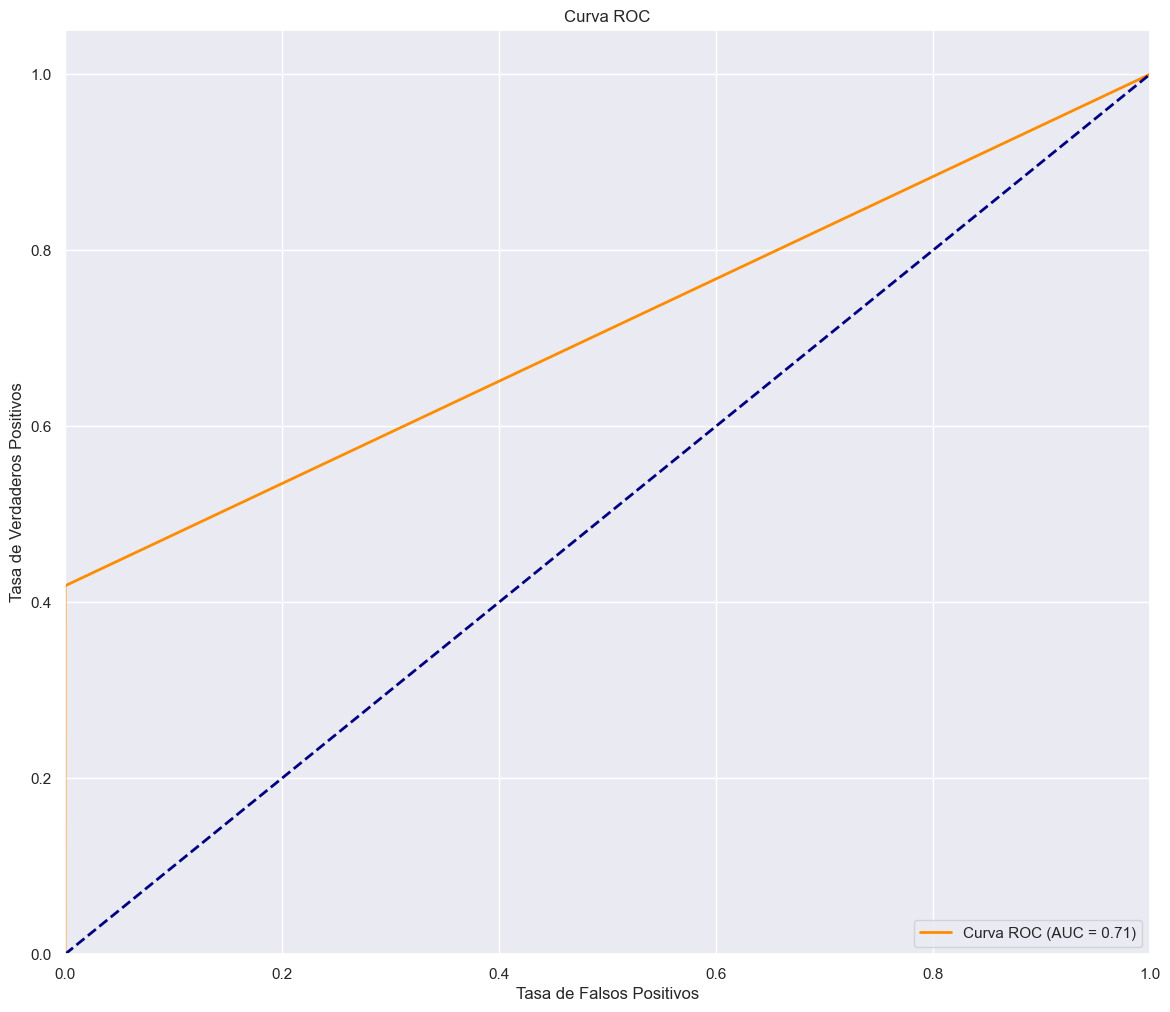

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_est)
roc_auc = auc(fpr, tpr)

print("AUC: ", roc_auc)
#plot_roc_curve(fpr, tpr, roc_auc)
#Un valor de AUC por encima de 0.5 indica que el modelo es mejor que el azar en términos de clasificación.
# Trazar la curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea de clasificación aleatoria
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [35]:
#TODO
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import mean_squared_error

# Definir y entrenar el modelo de regresion logística. DATOS DE ENTRENAMIENTO
l_reg_l2 = RidgeClassifier().fit(X_train, y_train)

# Obtener las predicciones para el conjunto de datos de testeo. DATOS DE EVALUACION
y_est = l_reg.predict(X_test)

# Obtener el error cuadratico medio y la precision
MSE_tst = mean_squared_error(y_test,y_est)
accuracy = l_reg.score(X_test, y_test)

# Imprimimos el error y precision del modelo
print('MSE : ' + str(MSE_tst))
print('Accuracy: ' + str(accuracy))

# Finalmente mostramos los datos para acernos una idea de como de cercana
# es la predicción. Se muestra para el atributo mean radius y texture. Cambiar de atributos
# para comprobar otras dimensiones


C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE : 0.0012484571102854424
Accuracy: 0.9987515428897146


In [36]:
from sklearn.model_selection import GridSearchCV

rang_alpha = np.logspace(-3, 1, 10)
tuned_parameters = [{'alpha': rang_alpha}]
nfold = 5

# Definir el modelo de regresion logística con validación cruzada y entrenarlo
# Configurar CV para que devuelva las puntuaciones de entrenamiento
ridge_CV = GridSearchCV(RidgeClassifier(), 
                        tuned_parameters, 
                        cv=nfold, 
                        return_train_score=True).fit(X_train, y_train)

# Obtener las predicciones para el conjunto de datos de testeo
y_est = ridge_CV.predict(X_test) 

# Obtener el error cuadratico medio y la precision
MSE_tst = mean_squared_error(y_est,y_test)
accuracy = ridge_CV.score(X_test,y_test)

# Se puede obtener el mejor parametro asi
alpha_CV = ridge_CV.best_params_['alpha']

print('MSE : ' + str(MSE_tst))
print('Accuracy: ' + str(accuracy))
print('Selected value of alpha: ' + str(alpha_CV))

C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\maria\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

KeyboardInterrupt: 

In [65]:
# Mostreos los resultados
import pandas as pd

cv_results = pd.DataFrame(ridge_CV.cv_results_)
accs = pd.concat([cv_results.param_alpha, cv_results.mean_train_score, cv_results.mean_test_score], axis=1, keys=["Alpha", "Train Accuracy", "Test Accuracy"])

for index, row in cv_results.iterrows():
    print("For alpha = %1.4f, validation accuracy is %2.2f (+/-%1.3f)%%"
        % (row['params']['alpha'], 100 * row['mean_test_score'], 100 * row['std_test_score'] / 2))
    
# Mostramos los resultados
melted_accs = accs.melt('Alpha', var_name="Type", value_name="Accuracy")
g = sns.lineplot(x="Alpha", y="Accuracy", hue='Type', data=melted_accs)
g = g.set(xscale="log")

NameError: name 'ridge_CV' is not defined

Confusion matrix
[[1588578       0]
 [   2052       0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


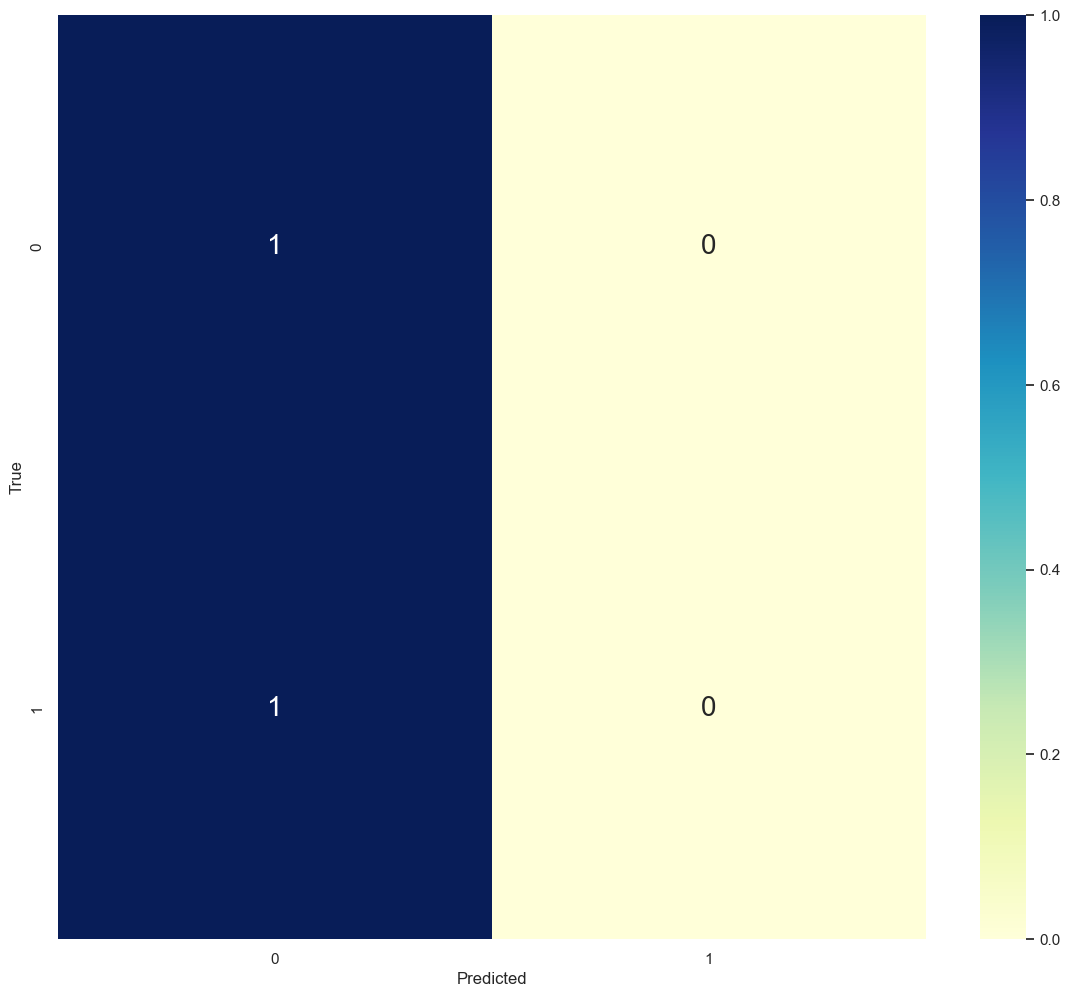

In [66]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y_test, y_est)
print('Confusion matrix')
print(CM)
CM_norm = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(CM_norm)
g = sns.heatmap(CM_norm, annot=True, cmap="YlGnBu", annot_kws={"size": 20}) \
       .set(ylabel='True', xlabel='Predicted')

In [33]:
# Modelo supervisado
# Normalizar datos
# Particion train y test
# Diseño del algoritmo
# Evaluacion del modelo

In [34]:
# Aplicamos la normalizacion min-max
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_norm = min_max_scaler.fit_transform(X.values)
X_norm = pd.DataFrame(X_norm)
X_norm.head()

,0,1,2,3
0,0.000106,0.002855,0.0,0.00
1,0.000020,0.000357,0.0,0.00
2,0.000002,0.000003,0.0,0.25
3,0.000002,0.000003,0.0,0.50
4,0.000126,0.000697,0.0,0.00


In [138]:
new_dat = pd.concat([X_norm, Y], axis=1)
new_dat

,0,1,2,3,es_fraude
0,0.000106,0.002855,0.000000,0.00,0
1,0.000020,0.000357,0.000000,0.00,0
2,0.000002,0.000003,0.000000,0.25,1
3,0.000002,0.000003,0.000000,0.50,1
4,0.000126,0.000697,0.000000,0.00,0
...,...,...,...,...,...
6362515,0.003674,0.005701,0.000954,0.50,1
6362516,0.068272,0.105923,0.000000,0.25,1
6362517,0.068272,0.105923,0.017912,0.50,1
6362518,0.009195,0.014265,0.000000,0.25,1


In [200]:
# Dividir los datos en conjuntos de entrenamiento y prueba
# Probar con 50000 datos sin fraude y 6000 con fraude
train = new_dat.groupby('es_fraude').apply(lambda x: x.sample(n=6000, random_state=42)).reset_index(drop=True)
test = pd.concat([new_dat, train]).drop_duplicates(keep=False).reset_index(drop=True)

In [201]:
u_train_x = train[[0, 1, 2, 3]]
u_test_x = test[[0, 1, 2, 3]]
u_train_y = train['es_fraude']
u_test_y = test['es_fraude']

In [202]:
# Estrategias para balancear las clases
# Undersampling
# Aplicar pesos a la red (Redes de neuronas)
# Aplicar validacion cruzada
# Reducir el threshold de clase (regresion logistica)
# Aplicar SMOTE
# https://academic.oup.com/bib/article/14/1/13/304457?login=false

In [203]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [204]:
# Creamos el modelo (perceptron multicapa)
model = Sequential(
    [
    Dense(4, input_dim=X_train.shape[1], activation='selu'),
    Dense(16 , activation='selu'), 
    Dense(8, activation='selu'),
    Dense(4, activation='selu'),
    Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [205]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 4)                 20        
                                                                 
 dense_53 (Dense)            (None, 16)                80        
                                                                 
 dense_54 (Dense)            (None, 8)                 136       
                                                                 
 dense_55 (Dense)            (None, 4)                 36        
                                                                 
 dense_56 (Dense)            (None, 1)                 5         
                                                                 
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


In [207]:
# Entrenamos el modelo
history = model.fit(u_train_x, u_train_y, shuffle=True, epochs=100, batch_size=16)

Epoch 1/100
750/750 [==============================] - 0s 480us/step - loss: 0.1518 - accuracy: 0.9385
Epoch 2/100
750/750 [==============================] - 0s 462us/step - loss: 0.1510 - accuracy: 0.9374
Epoch 3/100
750/750 [==============================] - 0s 482us/step - loss: 0.1442 - accuracy: 0.9421
Epoch 4/100
750/750 [==============================] - 0s 462us/step - loss: 0.1435 - accuracy: 0.9409
Epoch 5/100
750/750 [==============================] - 0s 462us/step - loss: 0.1386 - accuracy: 0.9451
Epoch 6/100
750/750 [==============================] - 0s 457us/step - loss: 0.1351 - accuracy: 0.9470
Epoch 7/100
750/750 [==============================] - 0s 479us/step - loss: 0.1383 - accuracy: 0.9447
Epoch 8/100
750/750 [==============================] - 0s 475us/step - loss: 0.1323 - accuracy: 0.9488
Epoch 9/100
750/750 [==============================] - 0s 477us/step - loss: 0.1289 - accuracy: 0.9494
Epoch 10/100
750/750 [==============================] - 0s 485us/step - l

In [208]:
prediction = model.predict(X_test)
prediction = np.round(prediction)

59649/59649 [==============================] - 19s 318us/step


In [209]:
def plot_curves(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)

    # Grafica de la precisión de entrenamiento y validación
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Grafica de la pérdida de entrenamiento y validación
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [173]:
plot_curves(history)

KeyError: 'val_accuracy'

In [210]:
from sklearn.metrics import confusion_matrix
def metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    precision = tp / (tp+fp)
    print('Especificidad: {:.2f}'.format(specificity))
    print('Sensibilidad: {:.2f}'.format(sensitivity))
    print('Precision: {:.2f}'.format(precision))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap='RdPu')
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Especificidad: 0.96
Sensibilidad: 1.00
Precision: 0.03


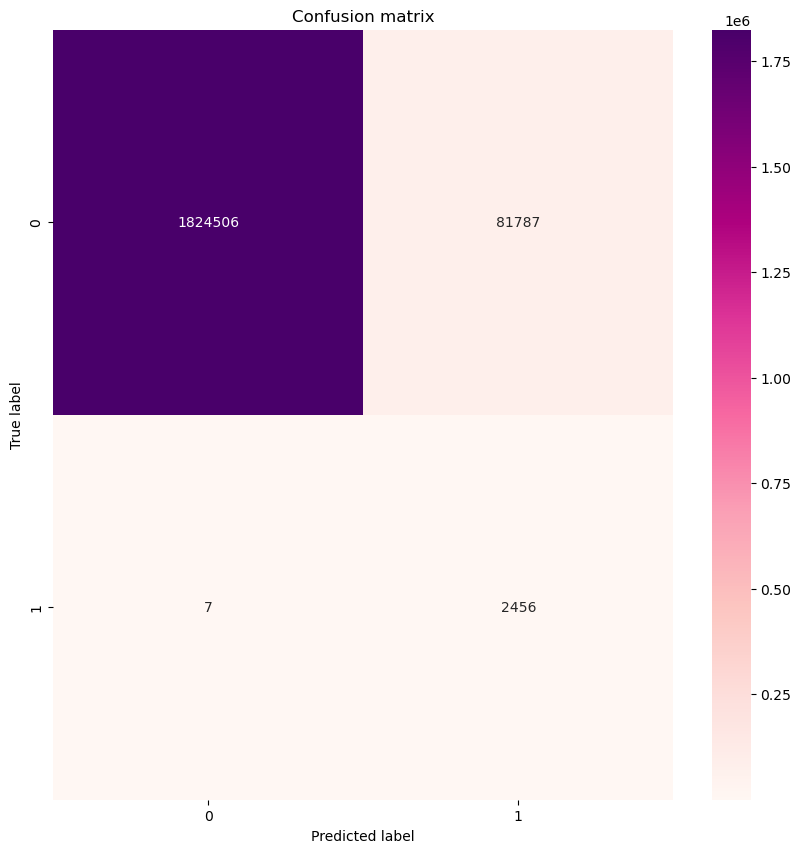

In [211]:
metrics(y_test, prediction)

In [176]:
from sklearn.linear_model import LogisticRegression

# Crear una instancia del modelo de regresión logística
model = LogisticRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Modificar el umbral de clasificación de la clase 1 (por ejemplo, a 0.7)
class_threshold = 0.95
model.classes_ = [0, 1]
model.coef_ = model.coef_
model.intercept_ = model.intercept_
model.threshold_ = class_threshold

# Predecir las etiquetas de los datos de entrenamiento
y_pred = model.predict(X_test)
y_pred = (y_pred > class_threshold).astype(int)

# Calcular el accuracy en el conjunto de entrenamiento
accuracy = model.score(X_test, y_test)

# Imprimir el accuracy
print("Training Accuracy:", accuracy)



C:\Users\maria\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.9986996766480367


Especificidad: 1.00
Sensibilidad: 0.00
Precision: 0.12


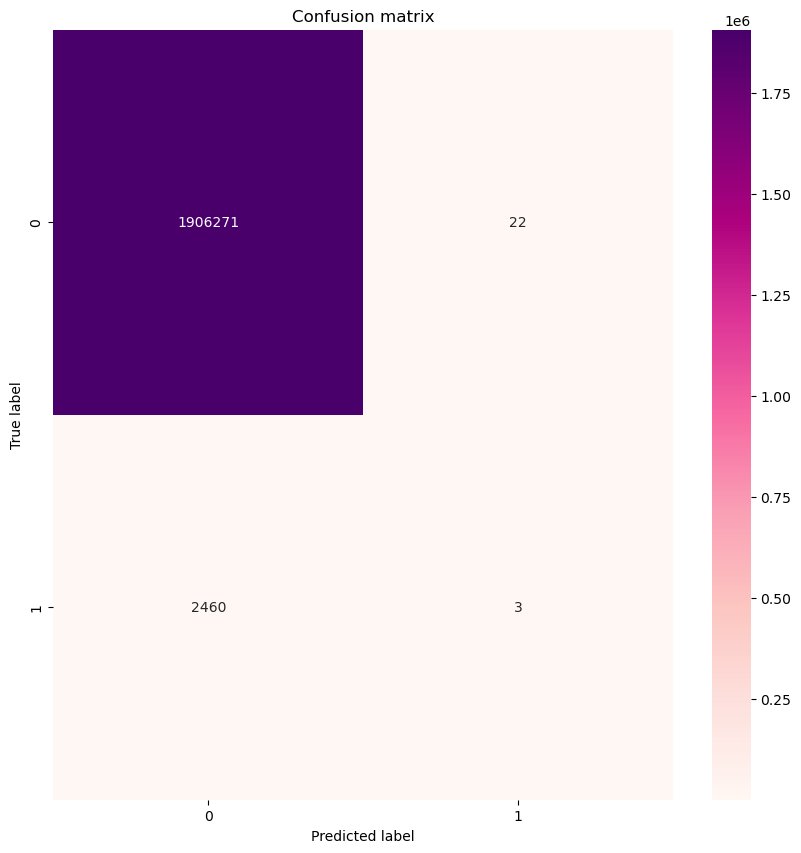

In [177]:
metrics(y_test, y_pred)

1.3097535777228729e-05